In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv("data.csv")
data

,Date,Price
0,2002-01-03,3835.000000
1,2002-01-04,3836.000000
2,2002-01-05,3837.000000
3,2002-01-06,3838.000000
4,2002-01-07,3839.000000
...,...,...
7455,2022-06-02,4051.000000
7456,2022-06-03,4050.000000
7457,2022-06-04,4050.333333
7458,2022-06-05,4050.666667


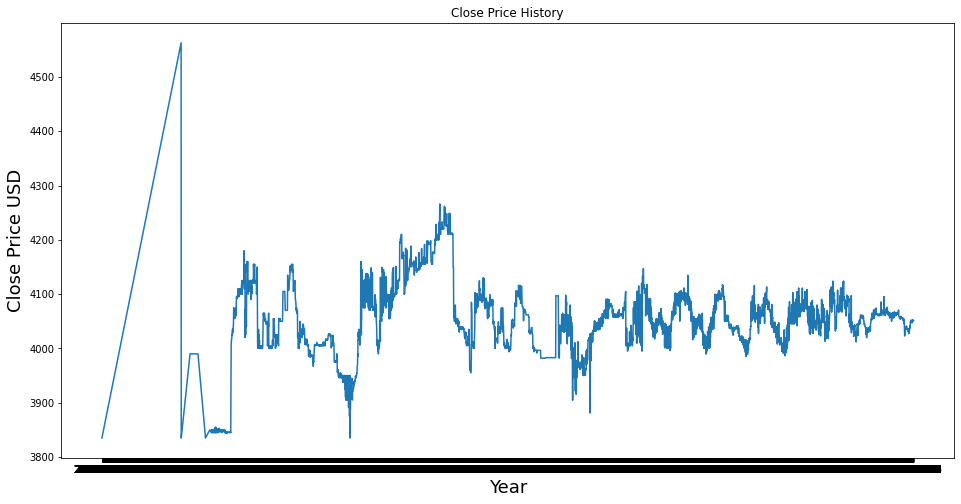

In [3]:
# check the shape of the data
data.shape

# visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(data['Date'], data['Price'])
plt.xlabel('Year', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.show()

In [4]:
# create a new dataframe with only the 'Price' column
data = data.filter(['Price'])

# convert the dataframe to a numpy array
dataset = data.values

# get the number of rows to train the model on (80% of the data)
training_data_len = int(np.ceil(0.8 * len(dataset)))

# normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# create the training data set
train_data = scaled_data[0:training_data_len, :]

# split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
# build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [6]:
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
5908/5908 [==============================] - 85s 14ms/step - loss: 0.0019
Epoch 2/5
5908/5908 [==============================] - 82s 14ms/step - loss: 9.2196e-04
Epoch 3/5
5908/5908 [==============================] - 81s 14ms/step - loss: 8.3352e-04
Epoch 4/5
5908/5908 [==============================] - 80s 14ms/step - loss: 6.9265e-04
Epoch 5/5
5908/5908 [==============================] - 82s 14ms/step - loss: 6.6440e-04


In [7]:
# create the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# create the x_test and y_test data sets
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# convert x_test to a numpy array
x_test = np.array(x_test)

# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# get the model's predicted values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE:', rmse)

47/47 [==============================] - 1s 11ms/step
RMSE: 10.06494990241926


C:\Users\vikreth\AppData\Local\Temp/ipykernel_10196/1610916049.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


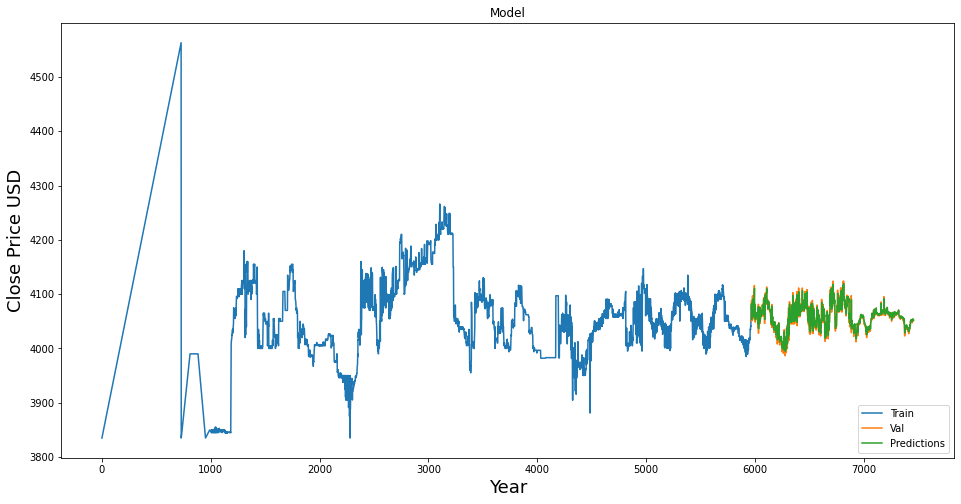

In [8]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Price'])
plt.plot(valid[['Price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [9]:
# create the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# create the x_test and y_test data sets
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# convert x_test to a numpy array
x_test = np.array(x_test)

# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# get the model's predicted values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

47/47 [==============================] - 0s 10ms/step


In [10]:
# calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE:', rmse)

RMSE: 10.06494990241926


In [11]:
# predict the next 10 days from 2022-06-06
last60days = scaled_data[-60:]
next10days = []

for i in range(10):
    next_day = model.predict(last60days.reshape(1, 60, 1))
    next10days.append(scaler.inverse_transform(next_day)[0][0])
    last60days = np.append(last60days[1:], next_day, axis=0)

1/1 [==============================] - 0s 20ms/step


In [12]:
# print the next 10 predicted closing prices
print('Next 10 predicted closing prices from 2022-06-07:')
for price in next10days:
    print(price)

Next 10 predicted closing prices from 2022-06-07:
4052.697
4054.0642
4055.2515
4056.296
4057.248
4058.1445
4059.003
4059.83
4060.6272
4061.395


In [13]:
from sklearn.metrics import mean_squared_error

# First we need to get the predictions from our model
test_predictions = model.predict(x_test)

# Undo the scaling to get predictions in USD
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, test_predictions)
print(f'MSE: {mse}')

47/47 [==============================] - 0s 9ms/step
MSE: 8721774100501.443
